In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load and preprocess image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((2048, 64))  # Resize to desired dimensions (width=2048, height=64)
    image = np.array(image) / 127.5 - 1  # Normalize to [-1, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Load dataset
def load_dataset(comp_dir, lg_dir):
    comp_images = []
    lg_images = []

    comp_filenames = sorted(os.listdir(comp_dir))
    lg_filenames = sorted(os.listdir(lg_dir))

    for comp_file, lg_file in zip(comp_filenames, lg_filenames):
        comp_image = load_and_preprocess_image(os.path.join(comp_dir, comp_file))
        lg_image = load_and_preprocess_image(os.path.join(lg_dir, lg_file))

        comp_images.append(comp_image)
        lg_images.append(lg_image)

    comp_images = np.array(comp_images)
    lg_images = np.array(lg_images)

    return comp_images, lg_images

# Cosine schedule
def cosine_schedule(num_steps, s=0.008):
    steps = np.arange(num_steps + 1)
    alpha_bar = np.cos(((steps / num_steps) + s) / (1 + s) * np.pi / 2) ** 2
    noise_levels = 1.0 - alpha_bar / alpha_bar[0]
    return noise_levels


2024-07-14 06:35:54.764088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 06:35:54.782771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 06:35:54.804606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 06:35:54.810811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 06:35:54.826785: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load the VGG19 model pretrained on ImageNet
vgg = VGG19(weights='imagenet', include_top=False)

# Select specific layers for perceptual loss computation
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2']
outputs = [vgg.get_layer(name).output for name in layer_names]

# Create a model that outputs these selected layers
vgg_model = Model(inputs=vgg.input, outputs=outputs)
vgg_model.trainable = False  # Freeze the VGG model

# Define the mean absolute error loss
mae_loss = MeanAbsoluteError()

def perceptual_loss(y_true, y_pred):
    # Convert grayscale images to 3-channel by duplicating the channel 3 times
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)

    # Compute VGG features for both true and predicted images
    y_true_features = vgg_model(y_true_rgb)
    y_pred_features = vgg_model(y_pred_rgb)

    # Compute perceptual loss as the mean absolute error between feature maps
    loss = 0.0
    for true_feat, pred_feat in zip(y_true_features, y_pred_features):
        loss += mae_loss(true_feat, pred_feat)
    
    return loss


2024-07-14 06:35:57.518543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43526 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0001:6f:00.0, compute capability: 8.9


In [3]:
class DiffusionModel(Model):
    def __init__(self, input_shape):
        super(DiffusionModel, self).__init__()
        self.unet = self.build_unet(input_shape)
        self.input_shape_ = input_shape
        self.dummy_noisy_input = tf.keras.layers.Input(shape=input_shape)
        self.dummy_condition_input = tf.keras.layers.Input(shape=input_shape)
        self.call([self.dummy_noisy_input, self.dummy_condition_input])  # This builds the model

    def build_unet(self, input_shape):
        def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
            x = layers.Conv2D(filters, kernel_size, strides, padding)(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
            return x

        inputs = layers.Input(shape=input_shape)
        condition = layers.Input(shape=input_shape)  # Condition image

        x = layers.Concatenate()([inputs, condition])

        # Encoder
        skips = []
        for filters in [64, 128, 256, 512]:
            x = conv_block(x, filters)
            skips.append(x)
            x = layers.MaxPooling2D()(x)

        # Bottleneck
        x = conv_block(x, 1024)

        # Decoder
        for filters, skip in zip([512, 256, 128, 64], reversed(skips)):
            x = layers.UpSampling2D()(x)
            x = layers.Concatenate()([x, skip])
            x = conv_block(x, filters)

        outputs = layers.Conv2D(1, kernel_size=1, activation='tanh')(x)
        return Model([inputs, condition], outputs)

    def call(self, inputs):
        noisy_images, condition_images = inputs
        return self.unet([noisy_images, condition_images])

    def train_step(self, data):
        images, condition_images = data
        noise_level = tf.random.uniform(shape=(), minval=0.1, maxval=1.0, dtype=tf.float32)
        noisy_images, noise = self.add_noise(images, noise_level)

        with tf.GradientTape() as tape:
            predicted_noise = self([noisy_images, condition_images], training=True)
            l1_loss = tf.reduce_mean(tf.abs(noise - predicted_noise))

            # Compute perceptual loss
            generated_images = noisy_images - predicted_noise
            perc_loss = perceptual_loss(images, generated_images)

            # Combine L1 loss and perceptual loss
            total_loss = l1_loss + perc_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": total_loss}

    def add_noise(self, images, noise_level):
        images = tf.cast(images, tf.float32)  # Ensure images are float32
        noise_level = tf.cast(noise_level, tf.float32)  # Ensure noise_level is float32
        noise = tf.random.normal(shape=tf.shape(images), dtype=tf.float32) * noise_level
        noisy_images = images + noise
        return noisy_images, noise


In [4]:
input_shape = (64, 2048, 1)
model = DiffusionModel(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

comp_images, lg_images = load_dataset('/Selected_Comp', '/Selected_LG')

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((lg_images, comp_images))
dataset = dataset.cache()  # Cache the dataset in memory
dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
dataset = dataset.batch(8)  # Batch the dataset
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  


Model: "diffusion_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ (None, 64, 2048, 1)    │    15,683,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,683,137 (59.83 MB)

 Trainable params: 15,677,249 (59.80 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100


I0000 00:00:1720938980.604468    4714 service.cc:146] XLA service 0x7f6270015370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720938980.604575    4714 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2024-07-14 06:36:20.804586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1720938981.073829    4714 assert_op.cc:38] Ignoring Assert operator grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1720938981.075698    4714 assert_op.cc:38] Ignoring Assert operator grayscale_to_rgb/assert_greater_equal/Assert/Assert
2024-07-14 06:36:21.128823: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUnif

  1/125 ━━━━━━━━━━━━━━━━━━━━ 46:14 22s/step - loss: 20.3902

I0000 00:00:1720938998.861613    4714 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - loss: 11.1393
Epoch 2/100
 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 7.7877

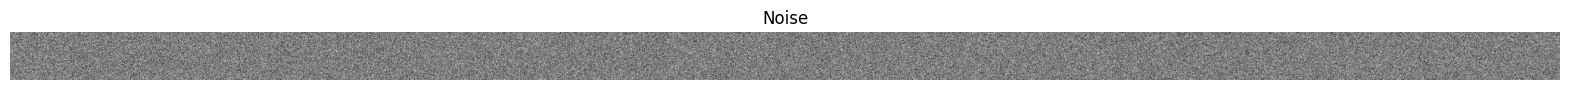

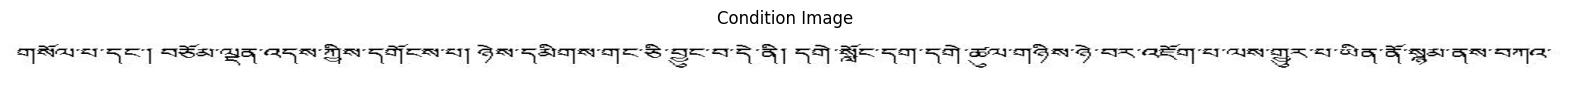

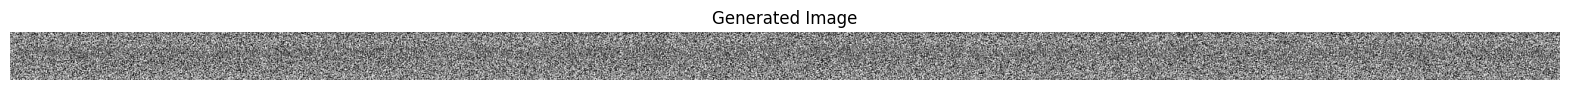

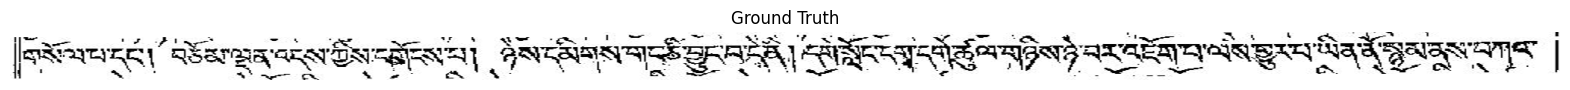

In [8]:
def generate_and_print_image(model, dataset, noise_level):
    # Take a single sample from the dataset
    for images, condition_images in dataset.take(1):
        break

    # Select the first image and condition image from the batch
    image = images[0:1]
    condition_image = condition_images[0:1]

    condition_image = tf.cast(condition_image, tf.float32)  # Ensure condition_images are float32
    noise_level = tf.cast(noise_level, tf.float32)  # Ensure noise_level is float32
    noisy_image, noise = model.add_noise(condition_image, noise_level)
    generated_image = model([noisy_image, condition_image])

    # Visualize the results
    def plot_single_image(title, image):
        plt.figure(figsize=(20, 5))
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis("off")
        plt.show()

    plot_single_image("Noise", noise.numpy().squeeze())
    plot_single_image("Condition Image", condition_image.numpy().squeeze())
    plot_single_image("Generated Image", generated_image.numpy().squeeze())
    plot_single_image("Ground Truth", image.numpy().squeeze())

# Example for generating and printing new image using a sample from the training data
noise_level = 0.5  # Choose a noise level
generate_and_print_image(model, dataset, noise_level)
